In [1]:
%matplotlib notebook
import os
import numpy as np
import torch 
from torch import nn 
from torch.nn import functional as F
import torch.utils.data as td
import torchvision as tv
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


### Part 1

The Stanford Cars dataset root directory is created below.

In [64]:
train_dir = "images/train"
val_dir = "images/val"
test_dir = "images/test"

image_size = (224,224)

normalize = tv.transforms.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5])

train_set = tv.datasets.ImageFolder(train_dir, tv.transforms.Compose([
    tv.transforms.Resize(image_size),
    tv.transforms.ToTensor(),
    normalize
    ]))

val_set = tv.datasets.ImageFolder(val_dir, tv.transforms.Compose([
    tv.transforms.Resize(image_size),
    tv.transforms.ToTensor(),
    normalize
    ]))


# test_set = tv.datasets.ImageFolder(test_dir, tv.transforms.Compose([
#     tv.transforms.Resize(image_size),
#     tv.transforms.ToTensor(),
#     normalize
#     ]))


<IPython.core.display.Javascript object>


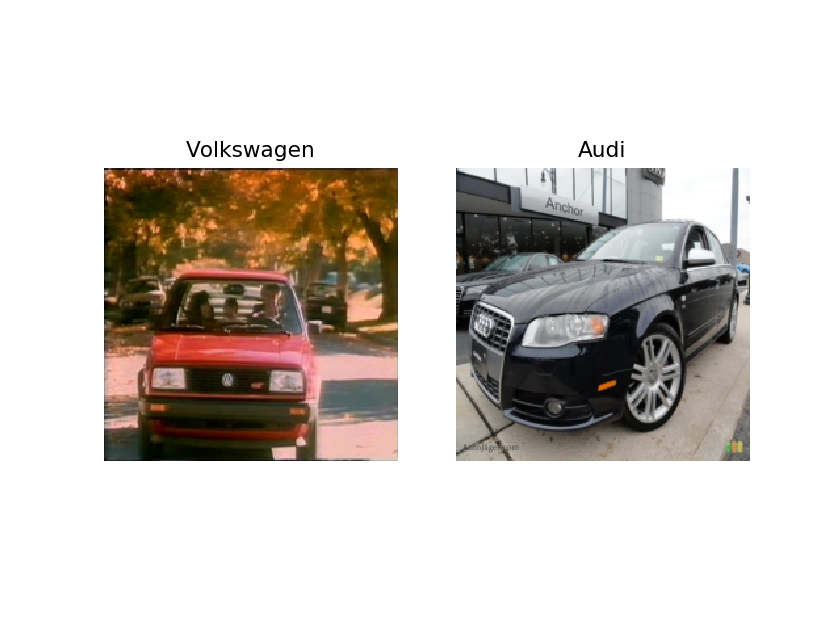

In [65]:

def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    h = ax.imshow(image)
    ax.axis('off')
    return h

# Visualize images:

x = train_set[10][0]
y = train_set[-1][0]
fig = plt.figure()
ax1 = fig.add_subplot(1,2,2)
myimshow(x,ax1)
plt.title("Audi")
ax2 = fig.add_subplot(1,2,1)
myimshow(y,ax2)
plt.title("Volkswagen")
plt.show()

### Part 2 - TRAINING


In [8]:
import nntools as nt
class NNClassifier(nt.NeuralNetwork):
    def __init__(self):
        super(NNClassifier, self).__init__()
        self.cross_entropy = nn.CrossEntropyLoss()
        
    def criterion(self, y, d):
        return self.cross_entropy(y, d)

###  With VGG16:

In [9]:
class VGG16Transfer(NNClassifier):
    def __init__(self, num_classes, fine_tuning=False):
        super(VGG16Transfer, self).__init__()
        vgg = tv.models.vgg16_bn(pretrained=True)
        for param in vgg.parameters():
            param.requires_grad = fine_tuning
        
        self.features = vgg.features
        self.classifier = vgg.classifier
        num_ftrs = vgg.classifier[6].in_features
        self.classifier[6] = nn.Linear(num_ftrs, num_classes)
        
    def forward(self, x):
        f = self.features(x)
        f = f.view(f.size(0), -1)
        y = self.classifier(f)
        return y

### Stats Manager Set-up

In [10]:
class ClassificationStatsManager(nt.StatsManager):
    def __init__(self):
        super(ClassificationStatsManager, self).__init__()
        
    def init(self):
        super(ClassificationStatsManager, self).init()
        self.running_accuracy = 0
        
    def accumulate(self, loss, x, y, d):
        super(ClassificationStatsManager, self).accumulate(loss, x, y, d)
        _, l = torch.max(y, 1)
        self.running_accuracy += torch.mean((l == d).float())
        
    def summarize(self):
        loss =super(ClassificationStatsManager, self).summarize()
        accuracy = 100 * self.running_accuracy / self.number_update
        return {'loss': loss,'accuracy': accuracy}

In [22]:
lr = 1e-3
net = VGG16Transfer(num_classes=12)
net = net.to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = ClassificationStatsManager()
exp1 = nt.Experiment(net, train_set, val_set, adam, stats_manager,output_dir="carclass_vgg1", perform_validation_during_training=True)

In [23]:
def plot(exp, fig, axes):
    axes[0].clear()
    axes[1].clear()
    axes[0].plot([exp.history[k][0]['loss'] for k in range(exp.epoch)],label="training loss")
    axes[0].plot([exp.history[k][1]['loss'] for k in range(exp.epoch)],label="evaluation loss")
    axes[1].plot([exp.history[k][0]['accuracy'] for k in range(exp.epoch)],label="training accuracy")
    axes[1].plot([exp.history[k][1]['accuracy'] for k in range(exp.epoch)],label="evaluation accuracy")
    axes[0].legend()
    axes[1].legend()
    axes[0].set_xlabel("Epoch")
    axes[1].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[1].set_ylabel("Accuracy")
    
    plt.tight_layout()
    fig.canvas.draw()

<IPython.core.display.Javascript object>


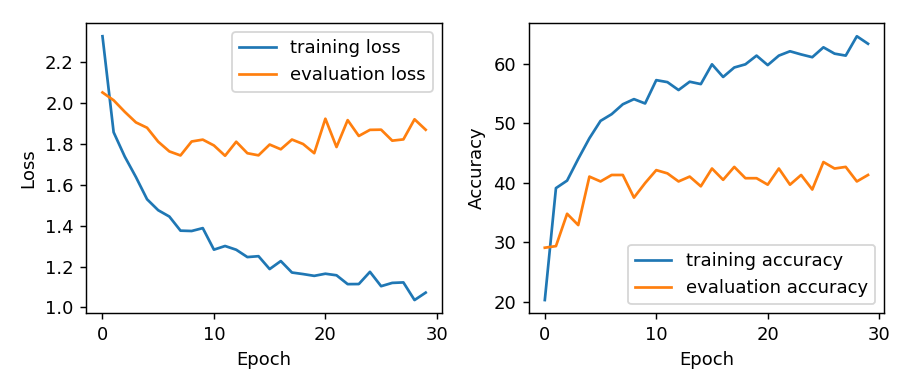

Start/Continue training from epoch 25
Epoch 26 (Time: 61.74s)
Epoch 27 (Time: 61.95s)
Epoch 28 (Time: 61.38s)
Epoch 29 (Time: 62.03s)
Epoch 30 (Time: 61.79s)
Finish training for 30 epochs


In [26]:
fig, axes = plt.subplots(ncols=2, figsize=(7, 3))
exp1.run(num_epochs=30, plot=lambda exp: plot(exp, fig=fig, axes=axes))

<IPython.core.display.Javascript object>


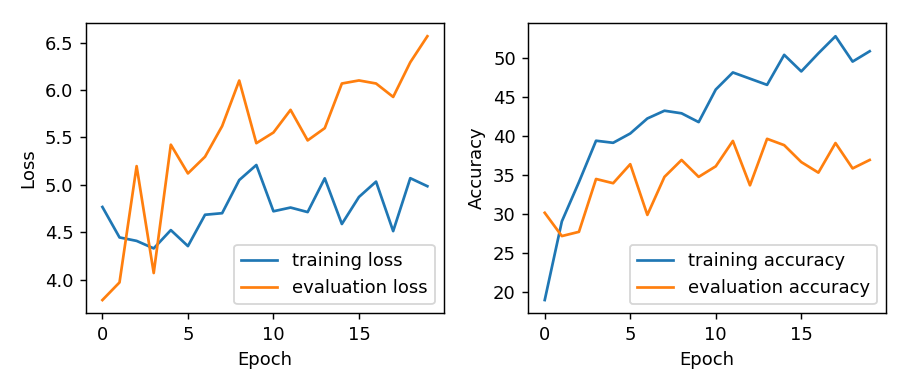

Start/Continue training from epoch 0
Epoch 1 (Time: 61.35s)
Epoch 2 (Time: 61.62s)
Epoch 3 (Time: 61.81s)
Epoch 4 (Time: 61.92s)
Epoch 5 (Time: 61.76s)
Epoch 6 (Time: 61.96s)
Epoch 7 (Time: 62.17s)
Epoch 8 (Time: 61.65s)
Epoch 9 (Time: 61.87s)
Epoch 10 (Time: 61.49s)
Epoch 11 (Time: 61.83s)
Epoch 12 (Time: 61.69s)
Epoch 13 (Time: 61.81s)
Epoch 14 (Time: 61.74s)
Epoch 15 (Time: 62.45s)
Epoch 16 (Time: 61.70s)
Epoch 17 (Time: 61.66s)
Epoch 18 (Time: 61.75s)
Epoch 19 (Time: 61.87s)
Epoch 20 (Time: 61.80s)
Finish training for 20 epochs


In [62]:
lr = 1e-2
net = VGG16Transfer(num_classes=12)
net = net.to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = ClassificationStatsManager()
exp4 = nt.Experiment(net, train_set, val_set, adam, stats_manager,output_dir="carclass_vgg2", perform_validation_during_training=True)
fig, axes = plt.subplots(ncols=2, figsize=(7, 3))
exp4.run(num_epochs=20, plot=lambda exp: plot(exp, fig=fig, axes=axes))

## With Resnet18 Model:

In [29]:
class Resnet18Transfer(NNClassifier):
    def __init__(self, num_classes, fine_tuning=False):
        super(Resnet18Transfer, self).__init__()
        resnet = tv.models.resnet18(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad = fine_tuning
        
        self.conv1 = resnet.conv1
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.pool1 = resnet.maxpool
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4
        self.pool2 = resnet.avgpool
        num_ftrs = resnet.fc.in_features
        self.fc = nn.Linear(num_ftrs, num_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool1(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        y = self.fc(x)
        return y

In [30]:
lr = 1e-3
net = Resnet18Transfer(num_classes=12)
net = net.to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = ClassificationStatsManager()
exp2 = nt.Experiment(net, train_set, val_set, adam, stats_manager,output_dir="carclass1", perform_validation_during_training=True)

<IPython.core.display.Javascript object>


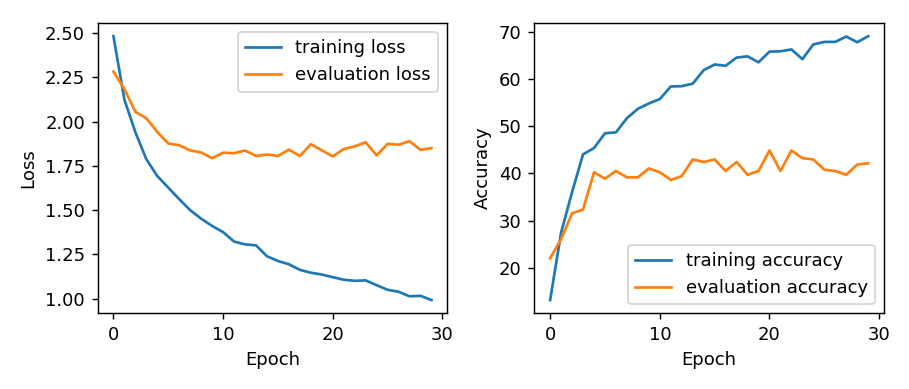

Start/Continue training from epoch 0
Epoch 1 (Time: 35.69s)
Epoch 2 (Time: 35.41s)
Epoch 3 (Time: 34.82s)
Epoch 4 (Time: 35.17s)
Epoch 5 (Time: 35.08s)
Epoch 6 (Time: 34.90s)
Epoch 7 (Time: 34.92s)
Epoch 8 (Time: 34.31s)
Epoch 9 (Time: 34.80s)
Epoch 10 (Time: 34.70s)
Epoch 11 (Time: 34.77s)
Epoch 12 (Time: 34.72s)
Epoch 13 (Time: 34.74s)
Epoch 14 (Time: 34.71s)
Epoch 15 (Time: 35.26s)
Epoch 16 (Time: 34.67s)
Epoch 17 (Time: 34.40s)
Epoch 18 (Time: 34.25s)
Epoch 19 (Time: 34.72s)
Epoch 20 (Time: 34.84s)
Epoch 21 (Time: 34.83s)
Epoch 22 (Time: 34.84s)
Epoch 23 (Time: 34.80s)
Epoch 24 (Time: 35.07s)
Epoch 25 (Time: 34.84s)
Epoch 26 (Time: 34.81s)
Epoch 27 (Time: 34.77s)
Epoch 28 (Time: 34.67s)
Epoch 29 (Time: 34.63s)
Epoch 30 (Time: 34.67s)
Finish training for 30 epochs


In [38]:
fig, axes = plt.subplots(ncols=2, figsize=(7, 3))
exp2.run(num_epochs=30, plot=lambda exp: plot(exp, fig=fig, axes=axes))

In [34]:
lr = 1e-2
net = Resnet18Transfer(num_classes=12)
net = net.to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = ClassificationStatsManager()
exp3 = nt.Experiment(net, train_set, val_set, adam, stats_manager,output_dir="carclass_res2", perform_validation_during_training=True)

<IPython.core.display.Javascript object>


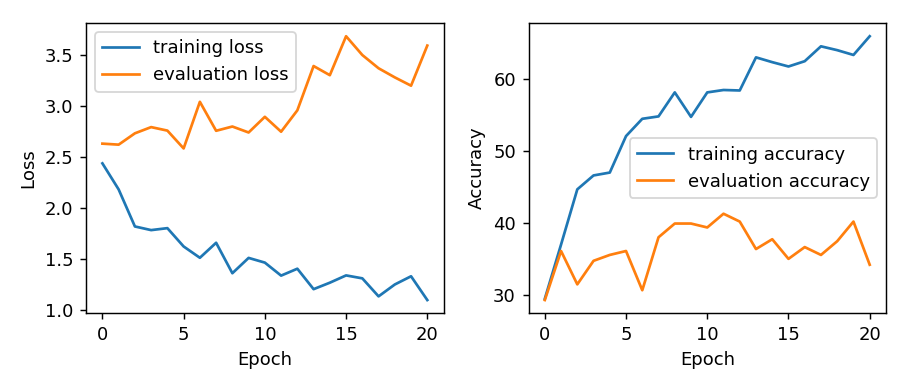

Start/Continue training from epoch 0
Epoch 1 (Time: 34.44s)
Epoch 2 (Time: 34.75s)
Epoch 3 (Time: 35.02s)
Epoch 4 (Time: 34.69s)
Epoch 5 (Time: 34.71s)
Epoch 6 (Time: 34.63s)
Epoch 7 (Time: 34.62s)
Epoch 8 (Time: 34.85s)
Epoch 9 (Time: 34.79s)
Epoch 10 (Time: 35.24s)
Epoch 11 (Time: 34.86s)
Epoch 12 (Time: 34.80s)
Epoch 13 (Time: 35.32s)
Epoch 14 (Time: 34.72s)
Epoch 15 (Time: 34.70s)
Epoch 16 (Time: 34.85s)
Epoch 17 (Time: 34.75s)
Epoch 18 (Time: 34.74s)
Epoch 19 (Time: 34.77s)
Epoch 20 (Time: 34.71s)
Epoch 21 (Time: 35.17s)
Finish training for 21 epochs


In [36]:
fig, axes = plt.subplots(ncols=2, figsize=(7, 3))
exp3.run(num_epochs=21, plot=lambda exp: plot(exp, fig=fig, axes=axes))

<IPython.core.display.Javascript object>


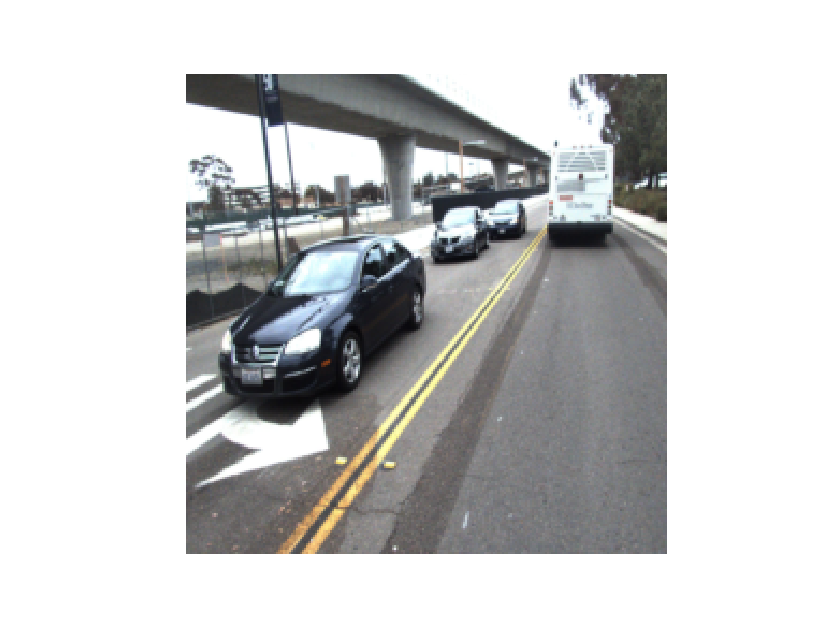

In [59]:

test_img = Image.open("images/test/4.png").convert('RGB')
transform = tv.transforms.Compose([
    tv.transforms.Resize(image_size),
    tv.transforms.ToTensor(),
    normalize
    ])

new = transform(test_img)
plt.figure()
myimshow(new)
plt.show()

In [60]:
output = net.forward(new.unsqueeze(0).cuda())
labels = ["Audi", "BMW", "Chevrolet", "Dodge", "Ford", "GMC", "Honda", "Hyundai", "Mercedes-Benz", "Nissan", "Toyota", "Volkswagen"]
idx = output.argmax().cpu().numpy()
print("The detected vehicle is of Make: ", labels[idx])
print(output)

The detected vehicle is of Make:  Dodge
tensor([[-5.8736,  2.3241,  1.7223,  6.1487,  2.3269, -1.0079,  0.1905,  0.2582,
          1.9512,  0.6169,  2.1860, -1.7983]], device='cuda:0',
       grad_fn=<AddmmBackward>)


### Performance comparison: 

In [39]:
print("For learning rate = 0.001")
vgg_eval = exp1.evaluate()
resnet_eval = exp2.evaluate()
print("Evaluation for VGG: {}".format(vgg_eval))
print("Evaluation for Resnet: {}".format(resnet_eval))

For learning rate = 0.001
Evaluation for VGG: {'accuracy': tensor(41.3043, device='cuda:0'), 'loss': 1.8686434600664221}
Evaluation for Resnet: {'accuracy': tensor(42.1196, device='cuda:0'), 'loss': 1.8501757901647817}


In [63]:
print("For learning rate = 0.01")
vgg_eval = exp4.evaluate()
resnet_eval = exp3.evaluate()
print("Evaluation for VGG: {}".format(vgg_eval))
print("Evaluation for Resnet: {}".format(resnet_eval))

For learning rate = 0.01
Evaluation for VGG: {'accuracy': tensor(36.9565, device='cuda:0'), 'loss': 6.567728695662125}
Evaluation for Resnet: {'accuracy': tensor(20.6522, device='cuda:0'), 'loss': 5.42356160412664}
